In [15]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv1D, MaxPooling1D, BatchNormalization
from keras.optimizers import RMSprop
from keras import backend as K
from sklearn import preprocessing

##  训练、测试数据

## 生成数据的函数

In [16]:
num_classes = 2
epochs = 50

train = np.load('C:/Users/78578/Desktop/project/data/train_npy.npy')
test = np.load('C:/Users/78578/Desktop/project/data/test_npy.npy')
x_train = train[:, 1:]
y_train = train[:, :1]

x_test = test[:, 1:]
y_test = test[:, :1]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [20]:
x_test.min()

-6.652

In [21]:
x_test.max()

51.762714

In [4]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

## 构建模型

In [5]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Conv1D(8, 3, activation="selu")(input)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)   
    x = Conv1D(8, 3, activation="selu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding="same")(x)             
    x = Flatten()(x)
    return Model(input, x)

input_shape = x_train.shape[1:]
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [6]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 1)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 100, 1)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 192)          296         input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]              

## 训练模型

In [7]:
# train
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))



Train on 25908 samples, validate on 26064 samples
Epoch 1/50
25908/25908 [==============================] - 6s 232us/step - loss: 78.0381 - accuracy: 0.4999 - val_loss: 17.3795 - val_accuracy: 0.5009
Epoch 2/50
25908/25908 [==============================] - 5s 191us/step - loss: 44.7404 - accuracy: 0.5002 - val_loss: 27.1414 - val_accuracy: 0.5007
Epoch 3/50
25908/25908 [==============================] - 5s 191us/step - loss: 27.8257 - accuracy: 0.5003 - val_loss: 17.8468 - val_accuracy: 0.5015
Epoch 4/50
25908/25908 [==============================] - 5s 194us/step - loss: 16.7752 - accuracy: 0.5004 - val_loss: 11.3634 - val_accuracy: 0.5033
Epoch 5/50
25908/25908 [==============================] - 5s 200us/step - loss: 9.5691 - accuracy: 0.5017 - val_loss: 6.3299 - val_accuracy: 0.5082
Epoch 6/50
25908/25908 [==============================] - 6s 228us/step - loss: 5.1792 - accuracy: 0.5045 - val_loss: 3.6278 - val_accuracy: 0.5191
Epoch 7/50
25908/25908 [=============================

## 可视化训练结果

Populating the interactive namespace from numpy and matplotlib


E:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


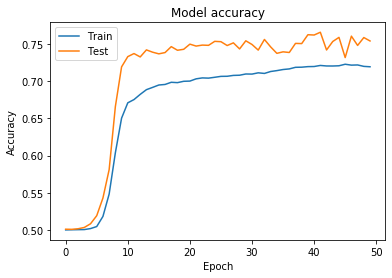

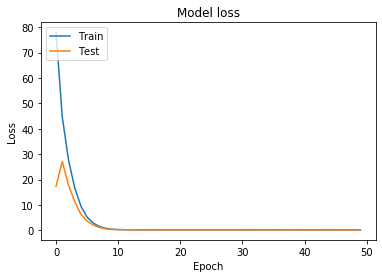

In [8]:
import matplotlib.pyplot as plt
%pylab inline
# 绘制训练 & 验证的准确率值
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
import numpy as np
from sklearn.preprocessing import normalize

x = np.random.rand(2)
norm = normalize(x[:,np.newaxis], axis=0).ravel()

In [10]:
x 

array([0.4926101 , 0.53799646])

In [11]:
norm

array([0.67531234, 0.73753186])

In [12]:
0.01551107 + 0.41292373

0.4284348

In [13]:
0.01551107 / 0.4284348

0.03620403851414498